In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
print(tf.__version__)
from tensorflow.keras.utils import to_categorical

# from tensorflow.keras import utils
# from tensorflow.keras.datasets import mnist
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# import seaborn as sns

2.11.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# from tensorflow.keras.datasets import cifar10
import os
import sys
import pickle


In [7]:
# !wget -c "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
# !gunzip -f "cifar-10-python.tar.gz"
# !tar -xvf cifar-10-python.tar

In [8]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def _load_each_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_the_file(path,training_file_name,test_file_name,num_train_samples):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 2):
        fpath = os.path.join(path, training_file_name + str(i))
        data, labels = _load_each_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, test_file_name)
    x_test, y_test = _load_each_batch(fpath)

    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)

In [9]:
(X_train, y_train), (X_test, y_test) = load_the_file('cifar-10-batches-py','data_batch_','test_batch',50000)

In [10]:
X_train = X_train/255
X_test = X_test/255
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train.shape

(50000,)

In [ ]:
# X_train = X_train[0:1000,:,:,:]
# y_train = y_train[0:1000]

In [14]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

In [15]:
# X_test = X_test[0:500,:,:,:]
# y_test = y_test[0:500]

In [16]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [17]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [18]:
y_train_cat.shape

(50000, 10)

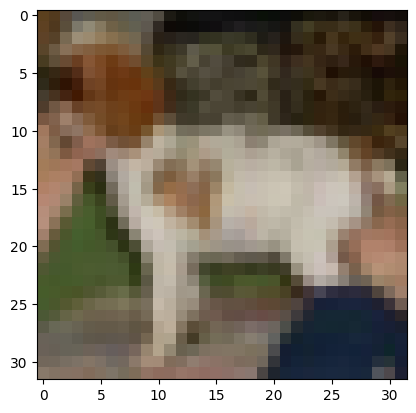

In [19]:
plt.imshow(X_test[12])

In [55]:
def execute_prediction_workflow(model_layer, learning_rate=None):
    print(f'Trying for: {model_layer} using learning rate: {learning_rate}')
    model_class = ''
    model_class = tf.keras.Sequential(model_layer)

    # print(model_class.summary())

    if learning_rate is None:
        model_class.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
    else:
        optimizr = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model_class.compile(optimizer=optimizr, loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
    
  
  # model_class.compile(loss='binary_crossentropy',
  #                   optimizer='adam',
  #                   metrics=['accuracy'])
  
  
  # fitModel = model_class.fit(X_train_scaled, y_train,
  #               epochs=51, validation_split=0.3, 
  #               # verbose=0
  #               )
  
    fitModel = model_class.fit(X_train, y_train_cat, batch_size=10, epochs=10, verbose=1, validation_data=(X_test, y_test_cat))
    print(f'fitModel.history: {fitModel.history}')

    y_predict = model_class.predict(X_test[:1,:])

    print(f'Predict shape: {y_predict.shape}')
    print(f'Prediction for record: {y_predict[0]}')
    print(f'Classification for 1st record: {np.argmax(y_predict[0])}')

    train_loss, train_acc = model_class.evaluate(X_train, y_train_cat)
    test_loss, test_acc = model_class.evaluate(X_test, y_test_cat)

    print(f'Classification accuracy on training data: {train_acc}')
    print(f'Classification accuracy on test data: {test_acc}')

    test_predict = model_class.predict(X_test)
    test_predict_labels = np.argmax(test_predict, axis=1)
    conf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=test_predict_labels)
    print(f'Confusion matrix on predictions: {conf_matrix}')

    fig = plt.figure(figsize = (15,4))
    fig.add_subplot(121)
    plt.plot(fitModel.history['categorical_accuracy'])
    plt.plot(fitModel.history['val_categorical_accuracy'])
    plt.legend(['Training Accuracy','Validation Accuracy'])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')

    fig.add_subplot(122)
    plt.plot(fitModel.history['loss'])
    plt.plot(fitModel.history['val_loss'])
    plt.legend(['Training Loss','Validation Loss'])
    plt.title('Training and validation Loss')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')

    return model_class

In [57]:
model_layers_list = []

#### Model 1

In [58]:
model_layers_list.append([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3]),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.1),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax')
])

#### Model 2

In [59]:
model_layers_list.append([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3]),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax')
])

#### Model 3

In [60]:
model_layers_list.append([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3]),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=10, activation='softmax')
])

#### Model 4

In [61]:
model_layers_list.append([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3]),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax')
])

#### Model 5

In [62]:
model_layers_list.append([
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3]),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax')
])

#### Model 6

In [63]:
model_layers_list.append([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape = [32, 32, 3]),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=9, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=10, activation='softmax')
])

#### Model 7

In [64]:
model_layers_list.append([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape = [32, 32, 3]),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.1),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
    Dropout(0.5),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=10, activation='softmax')
])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f53ccda8fa0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f53ccdbfc10>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f53ccdbfc70>, <keras.layers.regularization.dropout.Dropout object at 0x7f53cee06100>, <keras.layers.reshaping.flatten.Flatten object at 0x7f53cc4c2340>, <keras.layers.core.dense.Dense object at 0x7f53cc4c2640>, <keras.layers.core.dense.Dense object at 0x7f53cc4c2790>]


2022-12-06 20:36:34.697081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-06 20:36:34.702627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 20:36:34.703433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-06 20:36:34.704232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-06 20:36:34.704930: W tensorf

Epoch 1/10
5000/5000 [==============================] - 71s 14ms/step - loss: 0.3742 - categorical_accuracy: 0.8657 - val_loss: 1.5649 - val_categorical_accuracy: 0.4290
Epoch 2/10
5000/5000 [==============================] - 69s 14ms/step - loss: 0.2809 - categorical_accuracy: 0.8987 - val_loss: 1.4294 - val_categorical_accuracy: 0.4859
Epoch 3/10
5000/5000 [==============================] - 66s 13ms/step - loss: 0.2331 - categorical_accuracy: 0.9169 - val_loss: 1.4033 - val_categorical_accuracy: 0.5024
Epoch 4/10
5000/5000 [==============================] - 69s 14ms/step - loss: 0.1908 - categorical_accuracy: 0.9330 - val_loss: 1.4632 - val_categorical_accuracy: 0.5129
Epoch 5/10
5000/5000 [==============================] - 68s 14ms/step - loss: 0.1479 - categorical_accuracy: 0.9462 - val_loss: 1.5709 - val_categorical_accuracy: 0.5238
Epoch 6/10
5000/5000 [==============================] - 70s 14ms/step - loss: 0.1128 - categorical_accuracy: 0.9609 - val_loss: 1.7816 - val_categoric

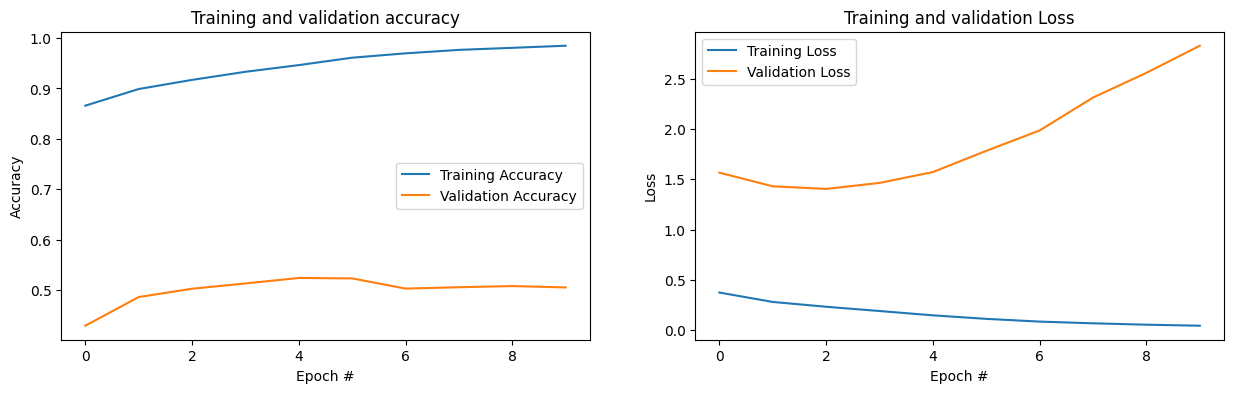

In [31]:
model_class = execute_prediction_workflow(model_layers_list[0])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f53cc4d0070>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f53cc4d0190>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f53cc4c2f40>, <keras.layers.regularization.dropout.Dropout object at 0x7f53cc4d0700>, <keras.layers.reshaping.flatten.Flatten object at 0x7f53cc4d10a0>, <keras.layers.core.dense.Dense object at 0x7f53cc4d13a0>, <keras.layers.core.dense.Dense object at 0x7f53cc4d14c0>]
Epoch 1/10
5000/5000 [==============================] - 33s 7ms/step - loss: 0.3774 - categorical_accuracy: 0.8628 - val_loss: 1.5811 - val_categorical_accuracy: 0.4316
Epoch 2/10
5000/5000 [==============================] - 33s 7ms/step - loss: 0.3002 - categorical_accuracy: 0.8923 - val_loss: 1.4046 - val_categorical_accuracy: 0.4920
Epoch 3/10
5000/5000 [==============================] - 33s 7ms/step - loss: 0.2650 - categorical_accuracy: 0.9041 - val_loss: 1.4175 - val_categorical_accuracy: 0.4887
Epoch 4/10


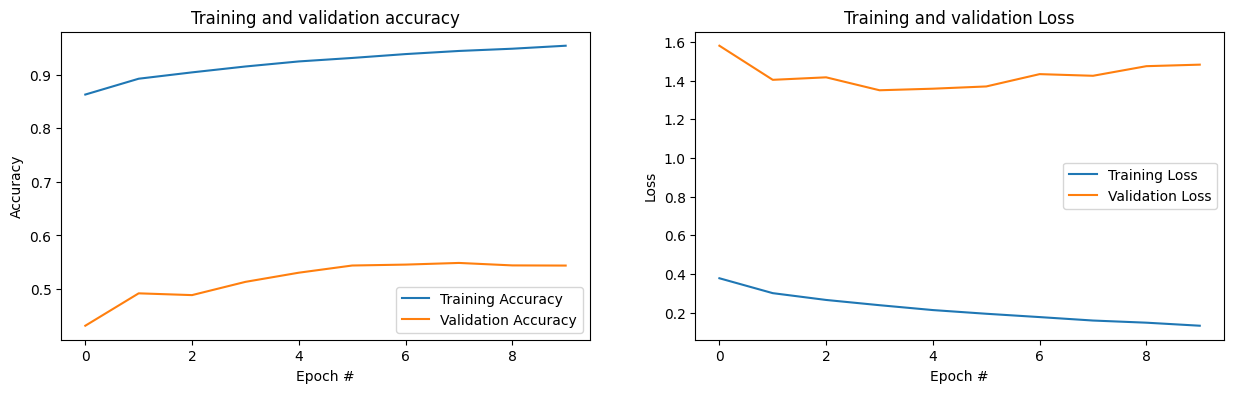

In [32]:
model_class = execute_prediction_workflow(model_layers_list[1])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5320540640>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f5320540730>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f5320540880>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5320540550>, <keras.layers.regularization.dropout.Dropout object at 0x7f531840d5b0>, <keras.layers.reshaping.flatten.Flatten object at 0x7f532054d550>, <keras.layers.core.dense.Dense object at 0x7f532054daf0>, <keras.layers.core.dense.Dense object at 0x7f532054dc40>, <keras.layers.core.dense.Dense object at 0x7f532054d790>]
Epoch 1/10
5000/5000 [==============================] - 32s 6ms/step - loss: 0.4211 - categorical_accuracy: 0.8444 - val_loss: 1.8218 - val_categorical_accuracy: 0.3227
Epoch 2/10
5000/5000 [==============================] - 32s 6ms/step - loss: 0.3590 - categorical_accuracy: 0.8675 - val_loss: 1.7317 - val_categorical_accuracy: 0.3649
Epoch 3/10
5000/5000 [==============================]

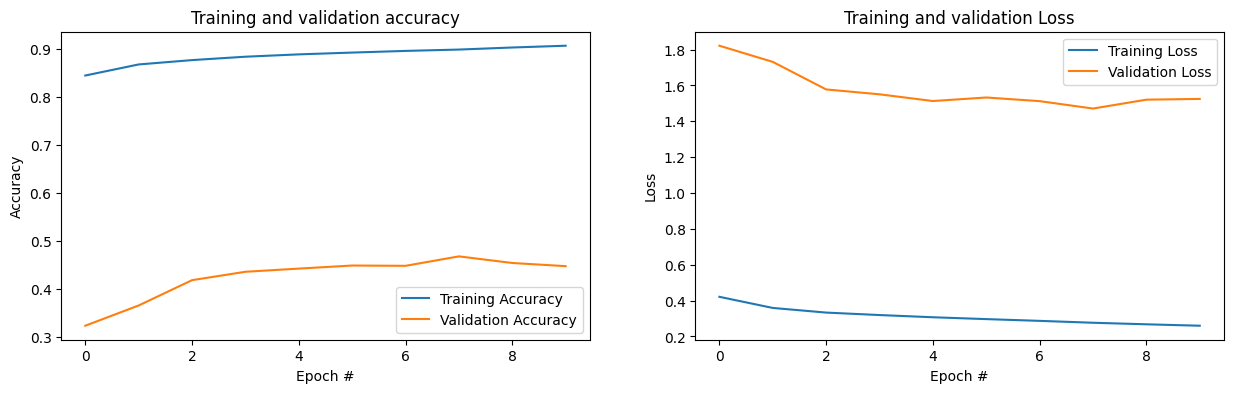

In [41]:
model_class = execute_prediction_workflow(model_layers_list[2])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f532053d940>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f532053d790>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f5318644370>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f532053d730>, <keras.layers.regularization.dropout.Dropout object at 0x7f5318419a60>, <keras.layers.reshaping.flatten.Flatten object at 0x7f53cc474490>, <keras.layers.core.dense.Dense object at 0x7f53cc474880>, <keras.layers.core.dense.Dense object at 0x7f53cc4747c0>, <keras.layers.core.dense.Dense object at 0x7f53185a7160>]
Epoch 1/10
5000/5000 [==============================] - 56s 11ms/step - loss: 0.3888 - categorical_accuracy: 0.8583 - val_loss: 1.5933 - val_categorical_accuracy: 0.4143
Epoch 2/10
5000/5000 [==============================] - 57s 11ms/step - loss: 0.3199 - categorical_accuracy: 0.8832 - val_loss: 1.5141 - val_categorical_accuracy: 0.4459
Epoch 3/10
5000/5000 [=============================

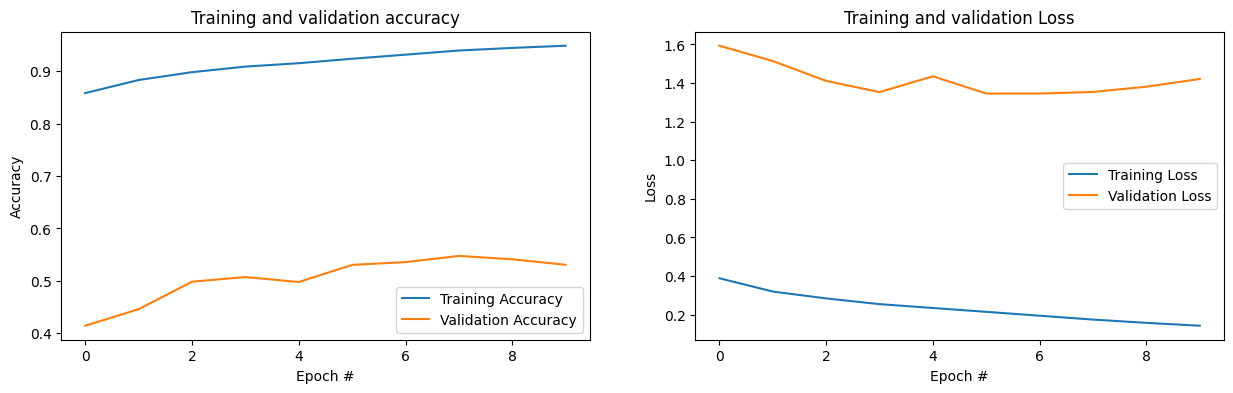

In [42]:
model_class = execute_prediction_workflow(model_layers_list[3])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f53184f4790>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f53184f4820>, <keras.layers.regularization.dropout.Dropout object at 0x7f53184f43a0>, <keras.layers.reshaping.flatten.Flatten object at 0x7f531857bcd0>, <keras.layers.core.dense.Dense object at 0x7f531857b7c0>, <keras.layers.core.dense.Dense object at 0x7f531857bd90>]
Epoch 1/10
5000/5000 [==============================] - 38s 8ms/step - loss: 0.3548 - categorical_accuracy: 0.8725 - val_loss: 1.5000 - val_categorical_accuracy: 0.4474
Epoch 2/10
5000/5000 [==============================] - 38s 8ms/step - loss: 0.2851 - categorical_accuracy: 0.8991 - val_loss: 1.4058 - val_categorical_accuracy: 0.4964
Epoch 3/10
5000/5000 [==============================] - 39s 8ms/step - loss: 0.2544 - categorical_accuracy: 0.9102 - val_loss: 1.3182 - val_categorical_accuracy: 0.5373
Epoch 4/10
5000/5000 [==============================] - 41s 8ms/step - loss: 0.2

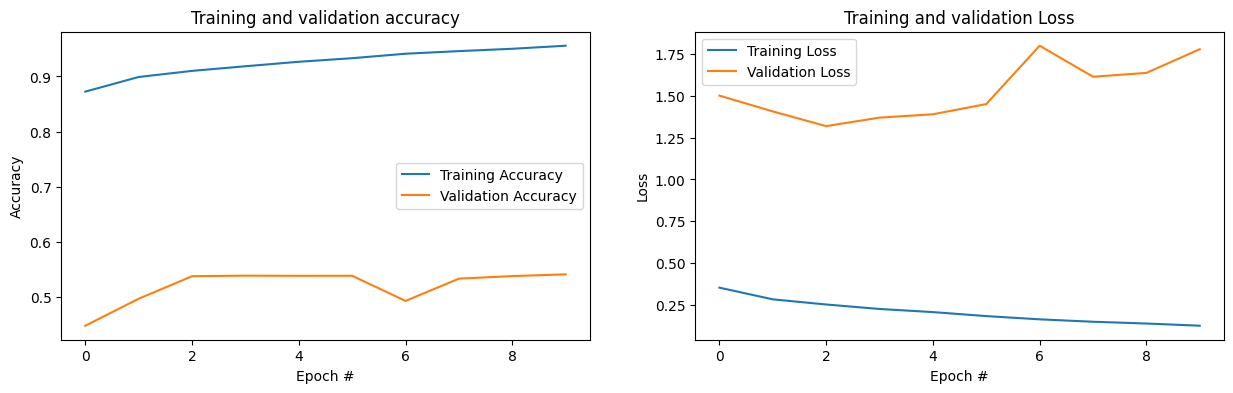

In [43]:
model_class = execute_prediction_workflow(model_layers_list[4])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f522c5d8430>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f522c5d8550>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f522c5d8a90>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f522c5d83d0>, <keras.layers.regularization.dropout.Dropout object at 0x7f522c5dd040>, <keras.layers.reshaping.flatten.Flatten object at 0x7f522c5dd940>, <keras.layers.core.dense.Dense object at 0x7f522c5ddc40>, <keras.layers.core.dense.Dense object at 0x7f522c5ddd60>, <keras.layers.core.dense.Dense object at 0x7f522c5da160>, <keras.layers.core.dense.Dense object at 0x7f522c5da490>] using learning rate: None
Epoch 1/10
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4465 - categorical_accuracy: 0.8318 - val_loss: 1.8406 - val_categorical_accuracy: 0.3218
Epoch 2/10
5000/5000 [==============================] - 54s 11ms/step - loss: 0.3579 - categorical_accuracy: 0.8666 - val_loss: 1.6894 - 

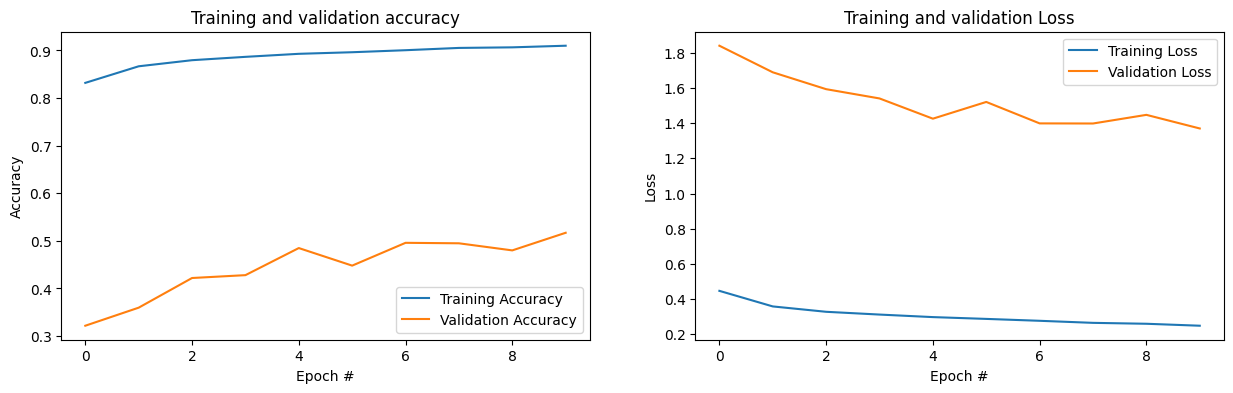

In [65]:
model_class = execute_prediction_workflow(model_layers_list[5])

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f53187aab20>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f53187aaf10>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f53184f4df0>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f53187aa760>, <keras.layers.regularization.dropout.Dropout object at 0x7f53184f4520>, <keras.layers.reshaping.flatten.Flatten object at 0x7f53184e8df0>, <keras.layers.core.dense.Dense object at 0x7f532053d190>, <keras.layers.core.dense.Dense object at 0x7f532053d0d0>, <keras.layers.core.dense.Dense object at 0x7f53cc4e4460>, <keras.layers.core.dense.Dense object at 0x7f53cc4e49a0>] using learning rate: 0.0001
Epoch 1/10
5000/5000 [==============================] - 53s 11ms/step - loss: 0.2293 - categorical_accuracy: 0.9165 - val_loss: 1.4109 - val_categorical_accuracy: 0.5061
Epoch 2/10
5000/5000 [==============================] - 54s 11ms/step - loss: 0.2220 - categorical_accuracy: 0.9192 - val_loss: 1.3950 

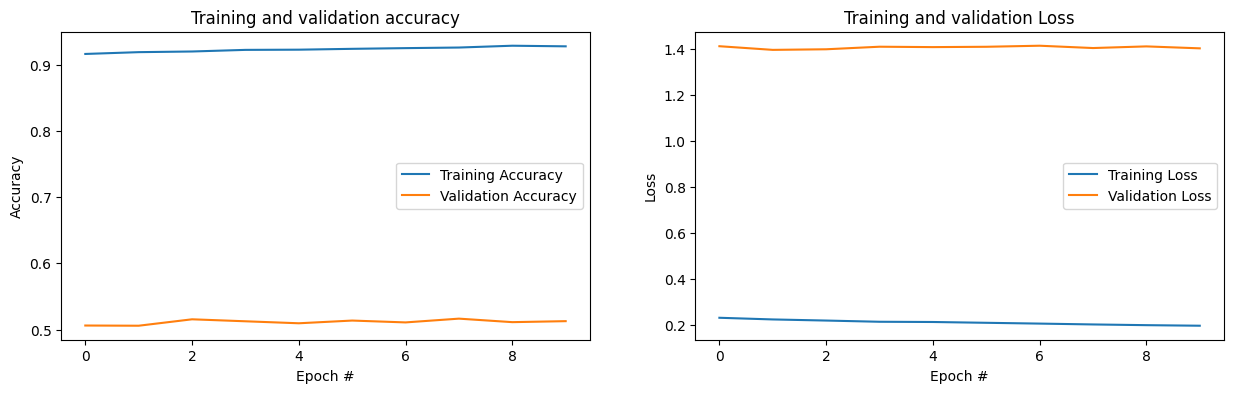

In [53]:
model_class = execute_prediction_workflow(model_layers_list[5], learning_rate=0.0001)

Trying for: [<keras.layers.convolutional.conv2d.Conv2D object at 0x7f522c5dac10>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f522c5d8370>, <keras.layers.regularization.dropout.Dropout object at 0x7f522c5dad60>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f522c5e4610>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f522c5e4790>, <keras.layers.regularization.dropout.Dropout object at 0x7f522c5e4c10>, <keras.layers.reshaping.flatten.Flatten object at 0x7f522c5ed190>, <keras.layers.core.dense.Dense object at 0x7f522c5ed460>, <keras.layers.core.dense.Dense object at 0x7f522c5ed580>, <keras.layers.core.dense.Dense object at 0x7f52742cc430>, <keras.layers.core.dense.Dense object at 0x7f522c5edd00>] using learning rate: None
Epoch 1/10
5000/5000 [==============================] - 59s 12ms/step - loss: 0.4119 - categorical_accuracy: 0.8458 - val_loss: 1.7950 - val_categorical_accuracy: 0.3409
Epoch 2/10
5000/5000 [==============================] - 59

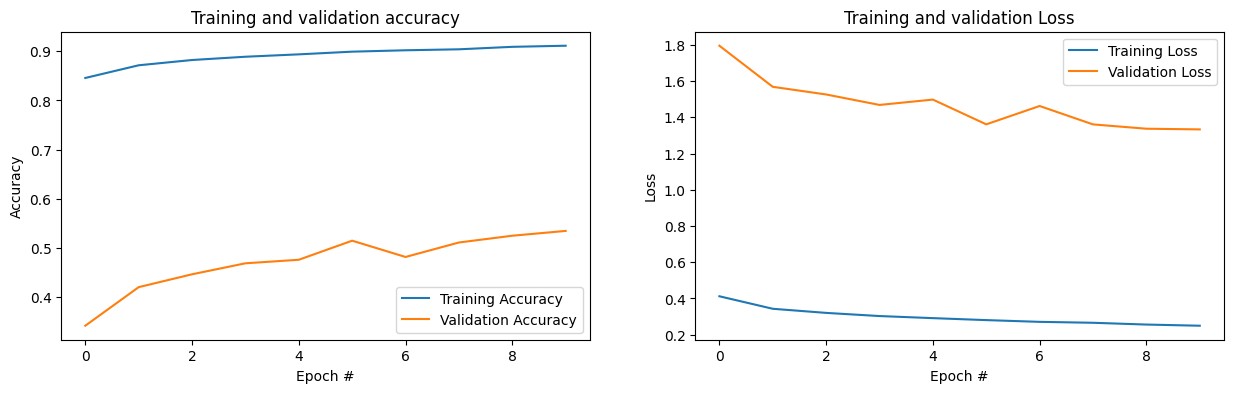

In [66]:
model_class = execute_prediction_workflow(model_layers_list[6])

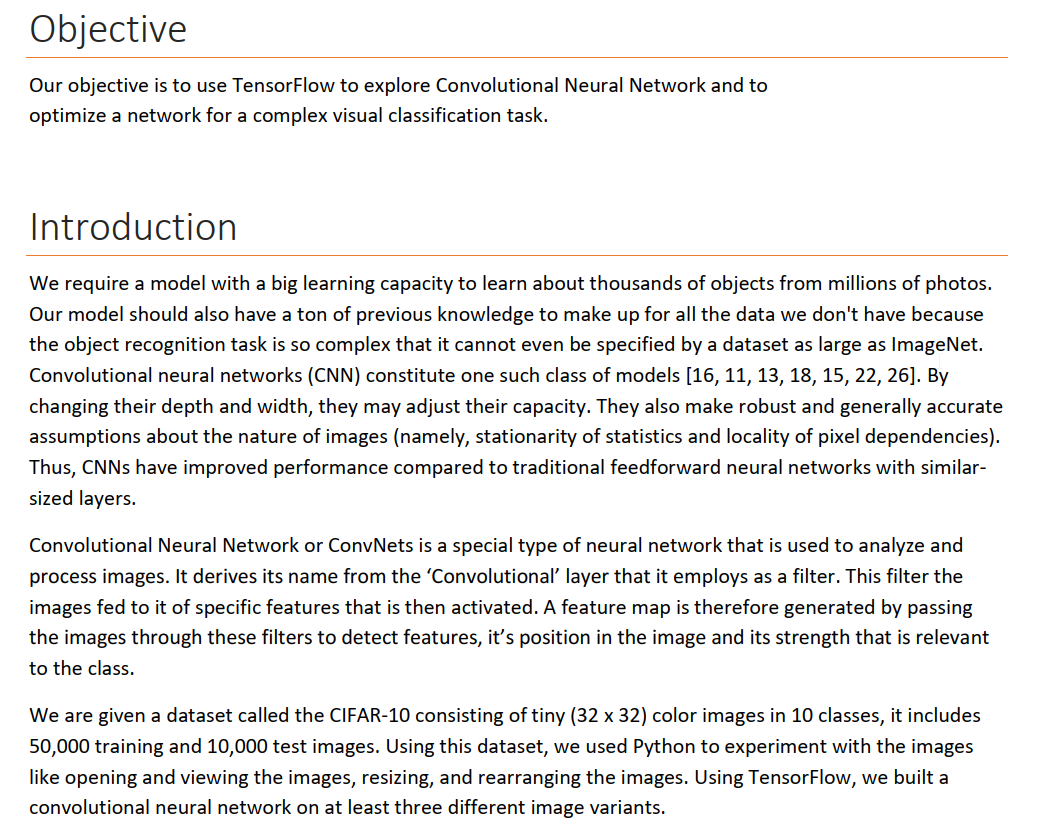

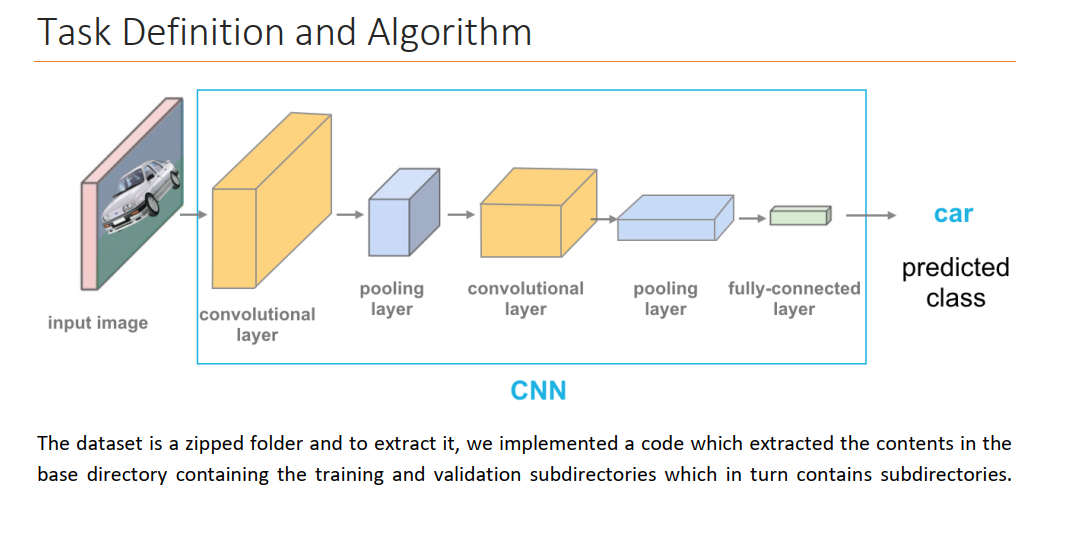

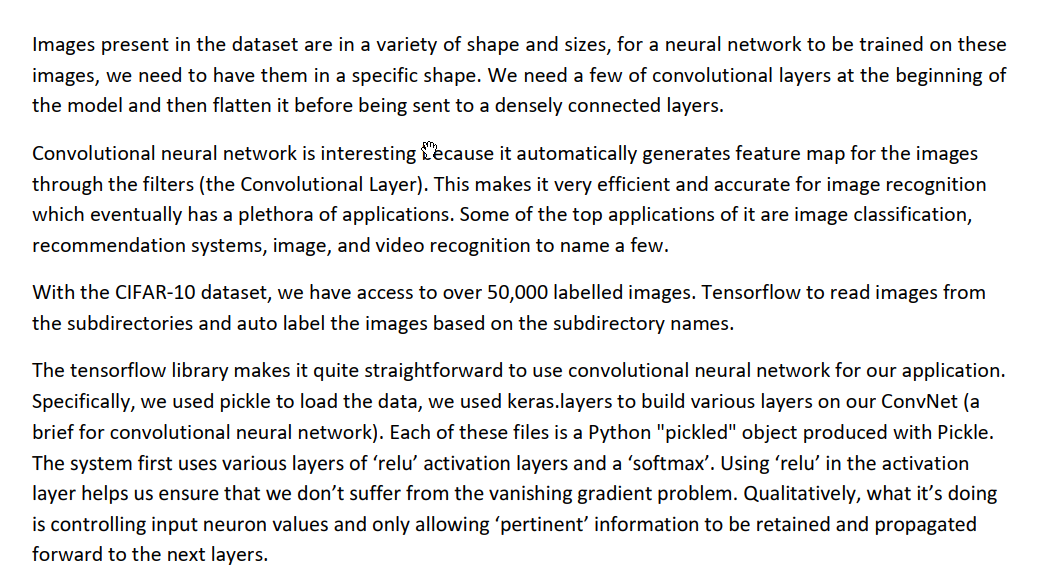

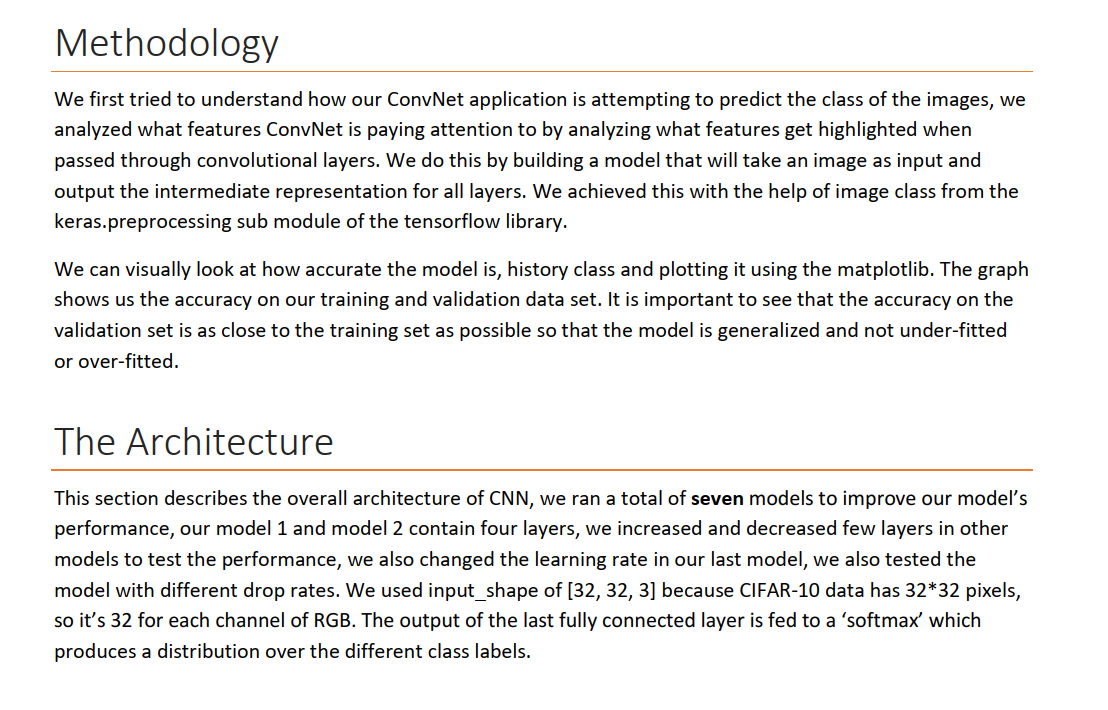

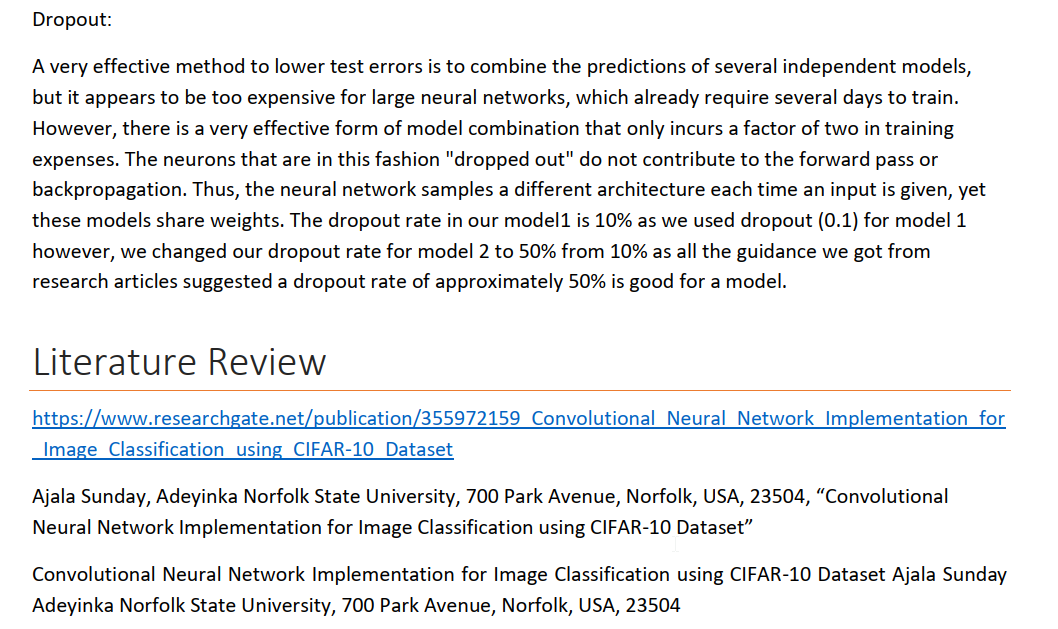

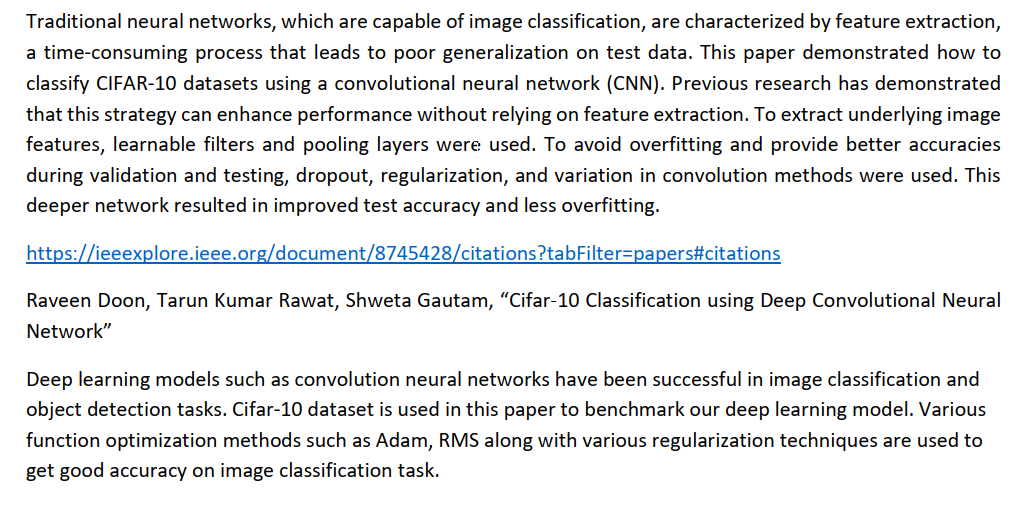

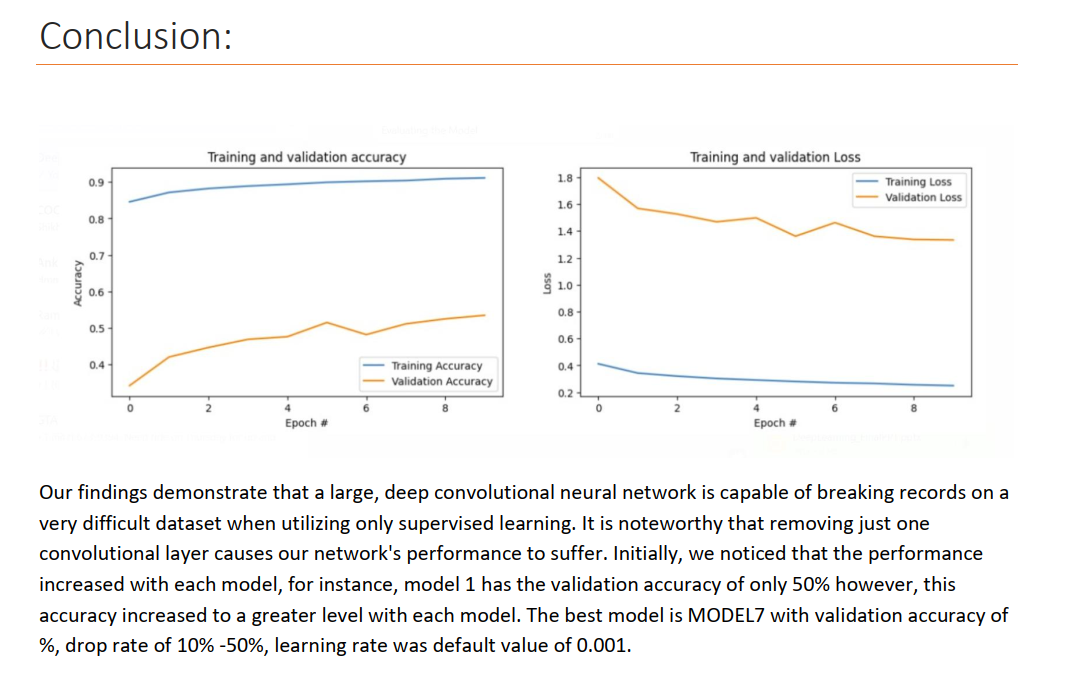

##### References

In [1]:
%%html
<a target="_blank" href="https://towardsdatascience.com/convolutional-neural-networks-with-tensorflow-2d0d41382d32">https://towardsdatascience.com/convolutional-neural-networks-with-tensorflow-2d0d41382d32</a><br>
<a target="_blank" href="https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-tensorflow/">https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-tensorflow/</a><br>
<a target="_blank" href="https://www.quora.com/In-TensorFlow-when-do-you-use-ReLU-in-activation-function-When-do-you-usesoftmax">https://www.quora.com/In-TensorFlow-when-do-you-use-ReLU-in-activation-function-When-do-you-usesoftmax</a><br>
<a target="_blank" href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">https://www.tensorflow.org/api_docs/python/tf/keras/layers/</a><br>
<a target="_blank" href="https://stackoverflow.com/questions/47892505/dropout-rate-guidance-for-hidden-layers-in-a-convolutionneural-network">https://stackoverflow.com/questions/47892505/dropout-rate-guidance-for-hidden-layers-in-a-convolutionneural-network</a><br>
<a target="_blank" href="https://www.cs.toronto.edu/~kriz/cifar.html">https://www.cs.toronto.edu/~kriz/cifar.html</a><br>
<a target="_blank" href="https://www.cs.toronto.edu/~kriz/">https://www.cs.toronto.edu/~kriz/</a><br>
<a target="_blank" href="https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf">https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf</a><br>
<a target="_blank" href="https://www.cs.toronto.edu/~kriz/imagenet_classification_with_deep_convolutional.pdf">https://www.cs.toronto.edu/~kriz/imagenet_classification_with_deep_convolutional.pdf</a><br>
<a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">https://www.tensorflow.org/tutorials/images/cnn</a><br>
<a target="_blank" href="https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b">https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b</a><br>
<a target="_blank" href="https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7#:~:text=The%20basic%20principle%20followed%20in,'">https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7</a><br>